In [4]:
import pandapower as pp
import geopandas as gpd
import math
import json
import pickle
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

from pandapower import control
from pandapower.control import ConstControl
from pandapower.timeseries import DFData
from pandapower.timeseries import OutputWriter
from pandapower.timeseries.run_time_series import run_timeseries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matlab
np.random.seed(42)

In [5]:
# LV_list=   ['214-1_1_5', '216-2_1_3', '214-1_2_2', '216-2_0_2', '216-1_1_3',
#            '216-1_2_4', '216-3_0_5', '39-1_0_4', '225-2_0_3', '225-4_0_3',
#            '225-1_0_6', '225-2_1_5', '225-3_0_6', '298-1_1_4', '298-4_0_2',
#            '225-5_0_5', '230-106_0_2', '298-2_0_5', '298-7_1_3', '298-7_0_3',
#            '298-5_0_5', '298-6_0_2','298-3_0_3', '298-8_0_7', '227-12_0_5',
#            '227-7_0_5', '227-10_1_3', '227-11_0_4', '230-150_0_2',
#            '227-9_0_5', '230-202_0_2', '230-180_0_4', '230-197_0_5',
#            '230-200_0_4', '230-202_1_3', '230-201_0_6', '230-211_0_2',
#            '230-212_0_3', '230-212_1_3', '230-108_0_6', '227-13_0_3',
#            '227-14_0_4', '227-8_0_10', '227-13_1_3', '227-1_0_5', '227-6_1_4',
#            '227-3_0_5', '298-9_0_5', '298-6_1_4', '298-4_1_5']

case_id='225-1_0_6'
zone='Midlands-Periurban'
MV_feeder = False
grid = "369_0"
folder ='298-6_0_2'#'225-1_0_6'#'298-4_1_5'#'216-1_1_3' 
scenario_year = 2050
weekday = "Friday"
day_start_ts = pd.to_datetime(f"{scenario_year}-01-07 00:00:00")
day_start = day_start_ts.day
day_end_ts = pd.to_datetime(f"{scenario_year}-01-08 00:00:00")
# month = day_start_ts.month
monitor_hr =int((day_end_ts - day_start_ts).total_seconds() / 3600)
path_controlled = f"{grid}/{scenario_year}_{weekday}_01_07_controlled"
path_uncontrolled = f"{grid}/{scenario_year}_{weekday}_01_07_uncontrolled"
grid_nodes, grid_edges = gpd.read_file(f"/Users/huiwen/Desktop/OneDrive/ETHZ/Thesis/LV/{zone}/{case_id}_nodes"), gpd.read_file(f"/Users/huiwen/Desktop/OneDrive/ETHZ/Thesis/LV/{zone}/{case_id}_edges")

In [105]:
def get_lv_consumer_bus(net):
    base_load=net.load[net.load.category=='base']
    lv_consumer_bus_idx= net.bus[net.bus.index.isin(base_load.bus) & (net.bus.vn_kv==0.4)].index
    mv_consumer_bus_idx=net.bus[net.bus.index.isin(base_load.bus) & (net.bus.vn_kv==20)].index
    lv_consumer_bus=net.bus_geodata.loc[lv_consumer_bus_idx]
    lv_consumer_bus_gdf = gpd.GeoDataFrame(lv_consumer_bus,
                                            geometry=gpd.points_from_xy(x=lv_consumer_bus.x, y=lv_consumer_bus.y),
                                            crs="epsg:2056")
    return lv_consumer_bus_gdf

def load_real_base_profile():
    # Winit Load Profile with base load of year 2024
    winti = pd.read_csv(f"/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/Timeseries/winterthur_load.csv")
    winti.zeitpunkt = pd.to_datetime(pd.to_datetime(winti.zeitpunkt).dt.strftime('%Y-%m-%d %H:%M:%S'))
    winti['datehour'] = winti.zeitpunkt.dt.strftime('%Y-%m-%d %H:00:00')
    winti_hourly = winti.groupby(['datehour']).bruttolastgang_kwh.sum()  # kWh
    return winti_hourly


def create_normalized_base_profile(day_start_ts):
    winti_profile = pd.DataFrame()
    winti_hourly = load_real_base_profile()
    winti_day_start = day_start_ts.replace(year=2023)
    selection_start_date = winti_day_start - pd.DateOffset(days=10)
    selection_end_date = winti_day_start + pd.DateOffset(days=10)
    for selected_date in pd.date_range(start=selection_start_date, end=selection_end_date):
        day_base_start = pd.to_datetime(pd.to_datetime(selected_date).strftime('%Y-%m-%d %H:%M:%S'))
        day_base_end = day_base_start + timedelta(hours=23)
        day_base = winti_hourly.loc[str(day_base_start):str(day_base_end)]
        day_base_norm = pd.DataFrame((day_base / day_base.max())).rename(
            columns={'bruttolastgang_kwh': 'norm'}).reset_index(drop=True)
        winti_profile = pd.concat([winti_profile, day_base_norm], ignore_index=True, axis=1)
    return winti_profile

def read_LV_zone_dict():
    # Data Processing
    LV_zone_dict = {}
    LV_path = ("LV/")

    with open("/Users/huiwen/Desktop/OneDrive/ETHZ/Thesis/file_folder_lv.json", 'r') as file:
        LV_zone_dict = json.load(file)
    return LV_zone_dict


def read_MV_nodes_all():
    MV_nodes_all = gpd.read_file('/Users/huiwen/Desktop/OneDrive/ETHZ/Thesis/MV_nodes_all.geojson')
    # Convert dtype
    MV_nodes_all['osmid'] = MV_nodes_all['osmid'].astype(int)
    # MV_nodes_all['consumers'] = MV_nodes_all['consumers'].astype(bool)
    MV_nodes_all = MV_nodes_all.to_crs(epsg=2056)
    MV_nodes_all['x'], MV_nodes_all['y'] = MV_nodes_all.geometry.x, MV_nodes_all.geometry.y
    return MV_nodes_all


def read_MV_edges_all():
    MV_edges_all = gpd.read_file('/Users/huiwen/Desktop/OneDrive/ETHZ/Thesis/MV_edges_all.geojson')
    return MV_edges_all

def get_Q(P, pf):
    """
    Calculate the reactive power (Q) given the real power (P) and the power factor (PF).
    Parameters:
    P: Real power in mW.
    pf: Power factor, ranging from -1(leading) to 1(lagging).

    Returns:
    Q: Reactive power (Q) in mvar.
    """
    S = P / pf
    Q = math.sqrt(S ** 2 - P ** 2)
    if pf < 0:
        Q = -Q
    return Q


def build_LV_net(case_id, zone=None, net=None, resp_MV=None):
    if zone is None:
        LV_zone_dict = read_LV_zone_dict()
        zone = LV_zone_dict[case_id]

    # Flag: Ture -> expand LV for selected MV, False->Create only LV network
    expand = False if net is None else True

    LV_pf = 0.97
    
    # Line types
    if zone.endswith('Urban'):
        LV_zone_line = {"line_type": "NAYY 4x240 SE", "line_type_in_lib": False, "r_ohm_per_km": 0.125,
                        "x_ohm_per_km": 0.08, "c_nf_per_km": 260, "g_us_per_km": 81.995568, "max_i_ka": 0.364, "type": "cs"} # c_nf_per_km not correct
    else:
        LV_zone_line = {"line_type": "NAYY 4x150 SE", "line_type_in_lib": True,"r_ohm_per_km": 0.208,
                        "x_ohm_per_km": 0.08, "c_nf_per_km": 261, "g_us_per_km": 81.995568, "max_i_ka": 0.27, "type": "cs"}

    # Trafo types
    if zone.endswith('rban'):
        LV_zone_trafo = {"trafo_type": "0.63 MVA 20/0.4 kV"}
    else:
        LV_zone_trafo = {"trafo_type": "0.25 MVA 20/0.4 kV"}

    # Read LV Grid Data
    grid_nodes, grid_edges = gpd.read_file(f"/Users/huiwen/Desktop/OneDrive/ETHZ/Thesis/LV/{zone}/{case_id}_nodes"), gpd.read_file(
        f"/Users/huiwen/Desktop/OneDrive/ETHZ/Thesis/LV/{zone}/{case_id}_edges")
    grid_nodes=grid_nodes.to_crs(epsg=2056)
    # Convert dtype
    grid_nodes['osmid'] = grid_nodes['osmid'].astype(int)
    # grid_nodes['consumers'] = grid_nodes['consumers'].astype(bool)

    # # Find respective MV bus connected to the LV grid
    MV_nodes_all = read_MV_nodes_all()
    resp_MV = MV_nodes_all[MV_nodes_all['lv_grid'] == case_id]

    if not expand:
        # Create LV Grid
        grid = pp.create_empty_network()
        trafo_tap = 0

        # resp_MV = MV_nodes_all[MV_nodes_all['lv_grid'] == case_id]
    else:
        grid = net
        trafo_tap = -2
    for index, node in grid_nodes.iterrows():
        # Add nodes to the grid
        pp.create_bus(grid, 0.4, name=case_id + '_node_' + str(node['osmid']),geodata=(node['x'], node['y']), type='n', zone=zone, in_service=True,max_vm_pu=1.03, min_vm_pu=0.97)

        # Index of the bus just created
        mask_this_LV_bus = (grid.bus.name == case_id + '_node_' + str(node['osmid']))
        this_LV_bus_id = grid.bus.loc[mask_this_LV_bus].index[0]

        # Add load to the grid
        if node['consumers']=='True' and node['el_dmd']!=0:
            pp.create_load(grid, bus=this_LV_bus_id, p_mw=node['el_dmd'], q_mvar=get_Q(node['el_dmd'], LV_pf),name=f'base_load_{case_id}_{node.osmid}',controllable=False,category='base',el_dmd=node['el_dmd'])

        # Add tansformer to the grid
        if node['source']:
            resp_MV_case_id, resp_MV_osmid = str(resp_MV['MV_case_id'].iloc[0]), str(resp_MV['osmid'].iloc[0])

            if not expand:
                # Create respective MV bus
                pp.create_bus(grid, vn_kv=20, name=f"MV_case_id_{resp_MV_case_id}_osmid_{resp_MV_osmid}",
                              geodata=(resp_MV['x'].iloc[0], resp_MV['y'].iloc[0]), type='b', zone=zone,
                              in_service=True, max_vm_pu=1.2, min_vm_pu=0.8)
                # Mask trafo HV/LV bus
                mask_trafo_hv_bus = (grid.bus.name == f"MV_case_id_{resp_MV_case_id}_osmid_{resp_MV_osmid}")
                pp.create.create_ext_grid(grid,bus=this_LV_bus_id,vm_pu=1,va_degree=0.0,in_service=True,controllable=True)
            else:
                mask_trafo_hv_bus = (grid.bus.name == f"{resp_MV_case_id}_node_{resp_MV_osmid}")

            trafo_hv_bus_id = grid.bus.loc[mask_trafo_hv_bus].index[0]
            pp.create_transformer(grid, name=f"trafo_on_{case_id}_node_{node['osmid']}", hv_bus=trafo_hv_bus_id,
                                  lv_bus=this_LV_bus_id, std_type=LV_zone_trafo['trafo_type'],tap_pos=trafo_tap)

    for index, edge in grid_edges.iterrows():
        # Mask the corresponding from/to bus for this edge
        mask_from_bus, mask_to_bus = (grid.bus.name == case_id + '_node_' + edge['u']), (
                grid.bus.name == case_id + '_node_' + edge['v'])
        from_bus_index, to_bus_index = grid.bus.loc[mask_from_bus].index[0], grid.bus.loc[mask_to_bus].index[0]

        # Add line to the grid
        pp.create_line_from_parameters(grid, name=f"{case_id}_{edge['u']}_{edge['v']}",
                                           from_bus=from_bus_index, to_bus=to_bus_index, length_km=edge['length'],
                                           r_ohm_per_km=edge['r']/edge['length']*edge['line_type'],
                                           x_ohm_per_km=edge['x']/edge['length']*edge['line_type'],
                                           c_nf_per_km=edge['b']*1000000000/(edge['length']*2*np.pi*50)/edge['line_type'], max_i_ka=edge['s_nom']/(np.sqrt(3)*0.4)/edge['line_type'],
                                           type=LV_zone_line['type'], in_service=True,max_loading_percent=70,parallel=edge['line_type'])
    print(f"Finish building LV {case_id}")
    return grid


def get_MV_line(line_type, OHL):
    if OHL:
        if line_type == 1:
            MV_zone_line = {"line_type": "48-AL1/8-ST1A 20.0", "line_type_in_lib": True}
        elif line_type == 2:
            MV_zone_line = {"line_type": "94-AL1/15-ST1A 20.0", "line_type_in_lib": True}
        elif line_type == 3:
            MV_zone_line = {"line_type": "122-AL1/20-ST1A 20.0", "line_type_in_lib": True}
        elif line_type == 4:
            MV_zone_line = {"line_type": "243-AL1/39-ST1A 20.0", "line_type_in_lib": True}
        elif line_type == 5:
            MV_zone_line = {"line_type": "2x122-AL1/20-ST1A 20.0", "line_type_in_lib": False,
                            "r_ohm_per_km": 0.2376 / 2, "x_ohm_per_km": 0.344 / 2, "c_nf_per_km": 10.3 * 2,
                            "g_us_per_km": 6.4716, "max_i_ka": 0.41 * 2, "type": "ol"}
        elif line_type == 6:
            MV_zone_line = {"line_type": "2x243-AL1/39-ST1A 20.0", "line_type_in_lib": False,
                            "r_ohm_per_km": 0.1188 / 2, "x_ohm_per_km": 0.32 / 2, "c_nf_per_km": 11 * 2,
                            "g_us_per_km": 6.911504, "max_i_ka": 0.645 * 2, "type": "ol"}
        else:
            print("Error: MV line type not defined!")
    else:
        if line_type == 1:
            MV_zone_line = {"line_type": "NA2XS2Y 1x70 RM/25 12/20 kV", "line_type_in_lib": True}
        elif line_type == 2:
            MV_zone_line = {"line_type": "NA2XS2Y 1x185 RM/25 12/20 kV", "line_type_in_lib": True}
        elif line_type == 3:
            MV_zone_line = {"line_type": "NA2XS2Y 1x240 RM/25 12/20 kV", "line_type_in_lib": True}
        elif line_type == 4:
            MV_zone_line = {"line_type": "NA2XS2Y 2x150 RM/25 12/20 kV", "line_type_in_lib": False,
                            "r_ohm_per_km": 0.206 / 2, "x_ohm_per_km": 0.116 / 2, "c_nf_per_km": 250 * 2,
                            "g_us_per_km": 157.0796, "max_i_ka": 0.319 * 2, "type": "cs"}
        elif line_type == 5:
            MV_zone_line = {"line_type": "2x122-AL1/20-ST1A 20.0", "line_type_in_lib": False, "r_ohm_per_km": 0.122 / 2,
                            "x_ohm_per_km": 0.112 / 2, "c_nf_per_km": 304 * 2, "g_us_per_km": 191.008833, "max_i_ka": 0.421 * 2,
                            "type": "cs"}
        elif line_type == 6:
            MV_zone_line = {"line_type": "2x243-AL1/39-ST1A 20.0", "line_type_in_lib": False, "r_ohm_per_km": 0.206 / 4,
                            "x_ohm_per_km": 0.116 / 4, "c_nf_per_km": 250 * 4, "g_us_per_km": 314.159265, "max_i_ka": 0.319 * 4,
                            "type": "cs"}
        else:
            print("Error: MV line type not defined!")
    return MV_zone_line


def build_MV_LV_net(MV_case_id):

    LV_zone_dict = read_LV_zone_dict()
    MV_nodes_all = read_MV_nodes_all()
    MV_pf = 0.9
    MV_zone_trafo = {"trafo_type": "25 MVA 110/20 kV"}
    # Read MV Grid Data
    MV_nodes, MV_edges = gpd.read_file(f"/Users/huiwen/Desktop/OneDrive/ETHZ/Thesis/MV/{MV_case_id}_nodes"), gpd.read_file(
        f"/Users/huiwen/Desktop/OneDrive/ETHZ/Thesis/MV/{MV_case_id}_edges")

    # Convert dtype
    MV_nodes['osmid'] = MV_nodes['osmid'].astype(int)
    MV_nodes = MV_nodes.to_crs(epsg=2056)
    # MV_nodes['consumers'] = MV_nodes['consumers'].astype(bool)

    # Create MV Grid
    net = pp.create_empty_network()

    for index, node in MV_nodes.iterrows():
        # Add buses
        pp.create_bus(net, 20, name=MV_case_id + '_node_' + str(node['osmid']), geodata=(node['x'], node['y']),
                      type='n', in_service=True,max_vm_pu=1.02,min_vm_pu=0.98)

        mask_this_MV_bus = (net.bus.name == MV_case_id + '_node_' + str(node['osmid']))
        this_MV_bus_id = net.bus.loc[mask_this_MV_bus].index[0]

        # Add transformer to the bus
        if node['source']:
            pp.create.create_ext_grid(net, bus=this_MV_bus_id, vm_pu=1, va_degree=0.0, in_service=True,controllable=True)
            
            # Connect HV/MV transforemr and HV bus
            pp.create_bus(net, 110, name=MV_case_id + '_HV_bus', geodata=(node['x'], node['y']), type='b',
                          in_service=True)
            mask_HV_bus = (net.bus.name == MV_case_id + '_HV_bus')
            HV_bus_id = net.bus.loc[mask_HV_bus].index[0]
            pp.create_transformer(net, name=f"trafo_on_{MV_case_id}_node_{node['osmid']}", hv_bus=HV_bus_id,
                                  lv_bus=this_MV_bus_id, std_type=MV_zone_trafo['trafo_type'],tap_pos=0)

        # Add load to the bus
        # Consumer not connected with LV
        if (node['consumers']=='True') and (node['lv_grid'] == '-1'):
            pp.create_load(net, bus=this_MV_bus_id, p_mw=node['el_dmd'], q_mvar=get_Q(node['el_dmd'], MV_pf),name=f"base_load_{MV_case_id}_{node.osmid}",controllable=False,category='base',el_dmd=node['el_dmd'])
        # Consumer connected with LV
        if (node['consumers']=='True') and (node['lv_grid'] != '-1'):
            LV_case_id = node['lv_grid']
            LV_zone = LV_zone_dict[node['lv_grid']]
            resp_MV = MV_nodes_all[MV_nodes_all['lv_grid'] == LV_case_id]
            net = build_LV_net(LV_case_id, LV_zone, net,resp_MV)

    for index, edge in MV_edges.iterrows():
        MV_zone_line = get_MV_line(edge['line_type'], edge['OHL'])
        # Mask the corresponding from/to bus for this edge
        mask_from_bus, mask_to_bus = (net.bus.name == MV_case_id + '_node_' + edge['u']), (
                net.bus.name == MV_case_id + '_node_' + edge['v'])
        from_bus_index, to_bus_index = net.bus.loc[mask_from_bus].index[0], net.bus.loc[mask_to_bus].index[0]

        # Add line to the grid
        pp.create_line_from_parameters(net, name=f"{MV_case_id}_{edge['u']}_{edge['v']}",
                                        from_bus=from_bus_index, to_bus=to_bus_index, length_km=edge['length'],
                                        r_ohm_per_km=edge['r']/edge['length'],
                                        x_ohm_per_km=edge['x']/edge['length'],
                                        c_nf_per_km=edge['b']*1000000000/(edge['length']*2*np.pi*50), max_i_ka=edge['s_nom']/(20*np.sqrt(3)),
                                        type=MV_zone_line['line_type'], in_service=True,max_loading_percent=70)


    print(f"Finish building MV {MV_case_id}")
    return net

# Base Load
def prepare_base_profile(net,day_start_ts):
    MV_pf = 0.9
    LV_pf = 0.97
    base_load = net.load.loc[net.load.category=='base']
    base_load_profile=pd.DataFrame(index=base_load.index,columns=['p_mw','q_mvar'])

    winti_profile = create_normalized_base_profile(day_start_ts)

    for idx, base in base_load.iterrows():
        v_lvl = net.bus.loc[net.load.loc[idx].bus].vn_kv
        if v_lvl == 0.4:
            pf = LV_pf
        else:
            pf = MV_pf
        el_dmd = net.load.loc[idx].el_dmd
        rand_norm_profile = winti_profile[np.random.choice(winti_profile.columns)].to_list()
        base_load_profile.at[idx, 'p_mw'] = [el_dmd * p for p in rand_norm_profile]
        base_load_profile.at[idx, 'q_mvar'] = [el_dmd * p * np.tan(np.arccos(pf)) for p in rand_norm_profile]
    return base_load_profile



# EV
def load_emob(path, grid, day_start_ts, monitor_hr, scenario_year):
    with open(f"/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/mobility/{path}/grid_{grid}_matched_{day_start_ts}_{monitor_hr}_{scenario_year}.pkl",
            "rb") as emob:
        emob = pickle.load(emob)
    emob_geometry = [Point(xy) for xy in zip(emob.end_x, emob.end_y)]
    emob_gdf = gpd.GeoDataFrame(emob, geometry=emob_geometry, crs='epsg:2056')
    return emob_gdf

def prepare_ev_profile(net,path,grid,day_start_ts,monitor_hr,scenario_year):
    LV_pf = 0.97
    MV_pf = 0.9
    emob_gdf = load_emob(path, grid, day_start_ts, monitor_hr, scenario_year)
    lv_consumer_bus_gdf = get_lv_consumer_bus(net)
    # Spatial Join Nearest lv_consumer_bus_gdf to the EV parking location
    emob_assigned = gpd.sjoin_nearest(emob_gdf, lv_consumer_bus_gdf, how='left', max_distance=20,
                                        distance_col="distance")  # Assign emob profile only to LV nodes
    emob_assigned = emob_assigned.loc[~pd.isnull(emob_assigned.index_right)]  # filter for successfully mapped EVs
    # map bus geometry
    emob_assigned.rename(columns={"index_right": "Bus"}, inplace=True)
    emob_assigned['bus_geometry'] = emob_assigned['Bus'].map(lv_consumer_bus_gdf['geometry'])


    ev_load = emob_assigned.copy().drop(columns=['geometry', 'bus_geometry'], axis=1)
    # Drop Duplicated Assigned
    duplicated_indices = ev_load.index.duplicated(keep='first')
    ev_unique = ev_load[~duplicated_indices].copy()
    ev_unique['parking_cnt'] = ev_unique.sort_values(by='dep_time').groupby('person').cumcount()
    #Avoid too many cars on 1 node
    ev_unique['node_ev_cnt'] = ev_unique.groupby('Bus')['distance'].rank(method='first',ascending=True)
    # ev_unique = ev_unique.loc[ev_unique.node_ev_cnt<=50]
    ev_unique['optimized_power_list'] = ev_unique['optimized_power_list'].apply(lambda row:[power/1e3 for power in row])
    ev_unique['index']=0
    for iter, ev in ev_unique.iterrows():
        pp.create_storage(
            net,
            bus=int(ev.Bus),
            name=f"ev_{ev.person}_{iter}_{int(ev.Bus)}_{ev.shifted_st_chg_time.hour}",
            p_mw=ev['chg rate']/1000,
            soc_percent=ev.update_SoE_bc/ev.B*100 if ev.parking_cnt==0 else 0, 
            max_e_mwh=ev.B/1000,
            min_e_mwh=0.005,
            type='ev',
            max_p_mw=ev['chg rate']/1000,
            min_p_mw=-ev['chg rate']/1000,
            max_q_mvar=0,
            min_q_mvar=0,
            controllable=True,
            person=ev.person,
            chg_rate=ev['chg rate']/1000,
            arr_time_idx=ev.arr_time_idx,
            park_end_time_idx=ev.park_end_time_idx,
            SoC_change=ev.SoE_change/ev.B*100,
            next_SoC_change=ev.next_SoE_change/ev.B*100,
            next_trip_e = ev.next_trip_e/1000
            )
        mask_this_ev = net.storage.name==f"ev_{ev.person}_{iter}_{int(ev.Bus)}_{ev.shifted_st_chg_time.hour}"
        this_ev_storage_idx = net.storage.loc[mask_this_ev].index
        pp.create_poly_cost(net, this_ev_storage_idx, "storage", cp1_eur_per_mw=-10, cp0_eur=0, cq1_eur_per_mvar=0, cq0_eur=0, cp2_eur_per_mw2=0, cq2_eur_per_mvar2=0)
        ev_unique.loc[iter,'index'] = this_ev_storage_idx
    ev_unique.set_index('index',inplace=True)  
    print("EV added")
    return ev_unique


# HP
def load_hp_profile(day_start_ts):
    hp_install = pd.read_json(f"/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/Load_demand/Heatpump/369_0_heatpump_demand_v2.json")  # power in kW
    doy = day_start_ts.day_of_year
    def get_day_hp_profile(yearly, doy):
        return yearly[doy]
    hp_install['p'] = hp_install['p'].apply(get_day_hp_profile, doy=doy)
    hp_install['p'] = hp_install['p'].apply(lambda row:[power/1e6 for power in row]) # convert from W to MW
    hp_install['q'] = hp_install['p'].apply(lambda row:[np.tan(np.arccos(0.97)) *power for power in row])
    hp_install_gdf = gpd.GeoDataFrame(hp_install, geometry=gpd.points_from_xy(x=hp_install.GKODE, y=hp_install.GKODN),crs="epsg:2056")
    return hp_install_gdf

def prepare_hp_profile(net,day_start_ts):
    hp_gdf=load_hp_profile(day_start_ts)
    lv_consumer_bus_gdf = get_lv_consumer_bus(net)
    hp_assigned = gpd.sjoin_nearest(hp_gdf, lv_consumer_bus_gdf, how='left', max_distance=20, distance_col="distance") # Find nearest bus for heatpump

    hp_assigned = hp_assigned.loc[~pd.isnull(hp_assigned.index_right)] # Filter for succesfully mapped HP
    hp_assigned.rename(columns={"index_right": "Bus"}, inplace=True)
    hp_assigned['bus_geometry'] = hp_assigned['Bus'].map(lv_consumer_bus_gdf['geometry'])
    hp_load = hp_assigned.copy().drop(columns=['geometry', 'bus_geometry'], axis=1)
    duplicated_EGID = hp_load.EGID.duplicated(keep='first')
    hp_unique = hp_load[~duplicated_EGID].copy()
    hp_unique['index']=0
    # hp_unique.set_index('EGID', inplace=True)
    for iter, hp in hp_unique.iterrows():
        pp.create_load(net, bus=hp['Bus'], p_mw=hp['PRT']/1e6, q_mvar=get_Q(hp['PRT']/1e6,0.97),name=f"hp_load_{int(hp.Bus)}_{hp.EGID}",controllable=False,category='hp',el_dmd=hp.PRT/1e6)
        mask_this_hp = net.load.name==f"hp_load_{int(hp.Bus)}_{hp.EGID}"
        this_hp_load_idx = net.load.loc[mask_this_hp].index
        hp_unique.loc[iter,'index'] = this_hp_load_idx
    hp_unique.set_index('index',inplace=True) 
    print("HP added")       
    return hp_unique


# PV
def load_pv_profile(day_start_ts):
    pv_install = pd.read_json(
        f"/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/Load_demand/PV/369_0_PV_powerlist_max_P_v3.json")  # power in kW
    doy = day_start_ts.day_of_year

    def get_day_pv_profile(yearly, doy):
        return yearly[doy]

    pv_install['pv_P_daily'] = pv_install['pv_P_daily'].apply(get_day_pv_profile, doy=doy)
    pv_install['pv_P_daily'] = pv_install['pv_P_daily'].apply(lambda row:[power/1e3 for power in row])
    pv_install['pv_Q_daily'] = pv_install['pv_P_daily'].apply(lambda row:[np.tan(np.arccos(0.97)) * power for power in row])
    pv_install_gdf = gpd.GeoDataFrame(pv_install, geometry=gpd.points_from_xy(x=pv_install.XCOORD, y=pv_install.YCOORD),
                                      crs="epsg:2056")
    return pv_install_gdf

def prepare_pv_profile(net,day_start_ts):
    pv_gdf = load_pv_profile(day_start_ts)
    lv_consumer_bus_gdf = get_lv_consumer_bus(net)
    pv_assigned = gpd.sjoin_nearest(pv_gdf, lv_consumer_bus_gdf, how='left', max_distance=20,
                                    distance_col="distance")  # Assign PV profile only to LV nodes
    pv_assigned = pv_assigned.loc[~pd.isnull(pv_assigned.index_right)]  # filter for successfully mapped PV
    pv_assigned.rename(columns={"index_right": "Bus"}, inplace=True)
    pv_assigned['bus_geometry'] = pv_assigned['Bus'].map(lv_consumer_bus_gdf['geometry'])
    pv_gen = pv_assigned.copy().drop(columns=['geometry', 'bus_geometry'], axis=1)# drop also , 'map_bus'

    # Drop Duplicated Assigned Nodes
    duplicated_DF_UID = pv_gen.DF_UID.duplicated(keep='first')
    pv_unique = pv_gen[~duplicated_DF_UID].copy()
    pv_unique['index']=0
    for iter,pv in pv_unique.iterrows():
        # pp.create_gen(net, bus=pv.Bus, p_mw=pv.max_P/1000, q_mvar=0,name=f"PV_{int(pv.Bus)}_{pv.DF_UID}",type="PV", max_p_mw=pv.max_P/1000, min_p_mw=0,controllable=True)#, min_q_mvar=0,max_q_mvar=np.tan(np.arccos(0.8))*pv.max_P/1000
        pp.create_sgen(net,bus=pv.Bus,name=f"PV_{int(pv.Bus)}_{pv.DF_UID}",p_mw=pv.max_P/1000,vm_pu=1,type='PV',controllable=True,max_p_mw=pv.max_P/1000,min_p_mw=0,max_q_mvar=None,min_q_mvar=None)#,max_q_mvar=np.tan(np.arccos(0.95))*pv.max_P/1000,min_q_mvar=-np.tan(np.arccos(0.95))*pv.max_P/1000
        mask_this_pv = net.sgen.name==f"PV_{int(pv.Bus)}_{pv.DF_UID}"
        this_pv_gen_idx = net.sgen.loc[mask_this_pv].index
        pv_unique.loc[iter,'index'] = this_pv_gen_idx
        pp.create_poly_cost(net, this_pv_gen_idx, "sgen", cp1_eur_per_mw=-1, cp0_eur=pv.max_P, cq1_eur_per_mvar=0, cq0_eur=0, cp2_eur_per_mw2=0, cq2_eur_per_mvar2=0)

    pv_unique.set_index('index',inplace=True)
    print("PV added")
    return pv_unique

In [106]:
# test = build_MV_LV_net(grid)
test = build_LV_net(folder)
base_load_profile = prepare_base_profile(test,day_start_ts) # prepare base_load profile
hp_load_profile= prepare_hp_profile(test,day_start_ts) # add heatpump load to grid
pv_load_profile=prepare_pv_profile(test,day_start_ts) # add PV to the grid
ev_load_profile = prepare_ev_profile(test,path_uncontrolled,grid,day_start_ts,monitor_hr,scenario_year)

Finish building LV 298-6_0_2
HP added
PV added
EV added


In [107]:
net=test
first_record = ev_load_profile[ev_load_profile['parking_cnt']==0]
first_record['init_SoC'] = first_record['augmented_SoE_bc']/first_record['B']*100
SoC_dict = dict(zip(first_record['person'],first_record['init_SoC']))
SoC_t = pd.DataFrame(index=SoC_dict.keys())
SoC_t[-1] = pd.Series(SoC_dict)
# parking_pre_p_dict = dict(zip(ev_load_profile.index,[0]*len(ev_load_profile)))

base_p = pd.DataFrame(base_load_profile.p_mw).T.apply(pd.Series.explode).reset_index(drop=True)
base_q = pd.DataFrame(base_load_profile.q_mvar).T.apply(pd.Series.explode).reset_index(drop=True)
hp_p = pd.DataFrame(hp_load_profile.p).T.apply(pd.Series.explode).reset_index(drop=True)
hp_q = pd.DataFrame(hp_load_profile.q).T.apply(pd.Series.explode).reset_index(drop=True)
pv_p = pd.DataFrame(pv_load_profile.pv_P_daily).T.apply(pd.Series.explode).reset_index(drop=True)
pv_q = pd.DataFrame(pv_load_profile.pv_Q_daily).T.apply(pd.Series.explode).reset_index(drop=True)
ev_p = pd.DataFrame(ev_load_profile.optimized_power_list).T.apply(pd.Series.explode).reset_index(drop=True)
# parking duration of each hour in hours
ev_park_t = pd.DataFrame(ev_load_profile.hourly_time_dict).T.apply(pd.Series.explode).reset_index(drop=True)/60

In [108]:
def ev_max_p_mw(sns,park_t,row,pre_ev_res):
    if (pre_ev_res<0).any(): #if any previous time step discharge->cannot charge anymore
        return 0
    # parked or not
    parked = (park_t>0)
    if (not parked) or (row['soc_percent']>95) or ((row['soc_percent']-row['next_SoC_change']>100) and (sns>=row.arr_time_idx) and (sns<=row.park_end_time_idx)):
        return 0
    else: #max energy can be charged until 100% SoC [MWh]
        if sns==row['arr_time_idx']: # Consider SoC jump driving in and out the grid if it's the snapshot when the ev arrives again in the grid
            SoE_left = row['max_e_mwh']*(1-(row['soc_percent']+row[ 'SoC_change'])/100)
        else:
            SoE_left = row['max_e_mwh']*(1-row['soc_percent']/100)            
        max_p_full = SoE_left/park_t # power needed to achieve 100 SoC within this hour
        return min(max(max_p_full,0), row['chg_rate'])
def ev_min_p_mw(sns,park_t,row,pre_ev_res):
    if (pre_ev_res>0).any():#if any previous time step charged->cannot discharge anymore
        return 0
    # parked or not
    parked = (park_t>0)
    SoC_lower_bound = max(row.next_trip_e/row.max_e_mwh*100,5)
    if (not parked) or (row['soc_percent']<5) or (row['soc_percent']<row.next_trip_e/row.max_e_mwh*100) or ((row['soc_percent']-row['next_SoC_change']<0)and (sns>=row.arr_time_idx) and (sns<=row.park_end_time_idx)):
        return 0
    else:
        # max energy can be discharged unitl 5% SoC [MWh]
        if (sns==row['arr_time_idx']): # Consider SoC jump driving in and out the grid if it's the snapshot when the ev arrives again in the grid
            SoE = row['max_e_mwh']*(row['soc_percent']-row['SoC_change']-SoC_lower_bound)/100 
        else:
            SoE = row['max_e_mwh']*(row['soc_percent']-SoC_lower_bound)/100 
        min_p_empty =-SoE/park_t # power needed to achieve 100 SoC within this hour
        return max(min(0,min_p_empty), -row['chg_rate'])

/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_27597/2185168435.py:84: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


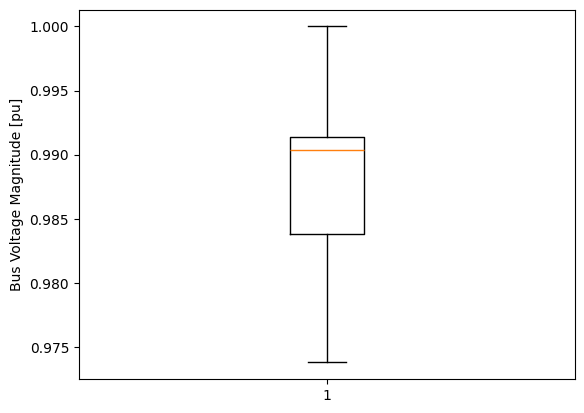

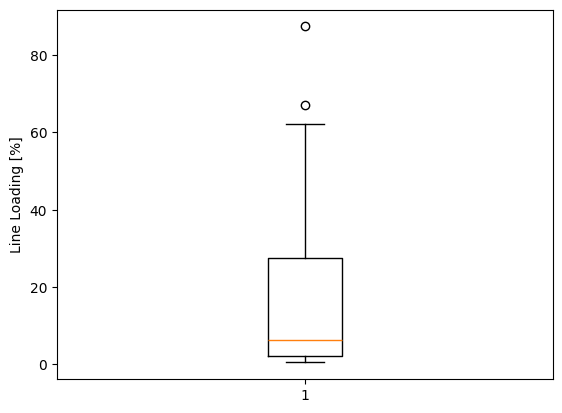

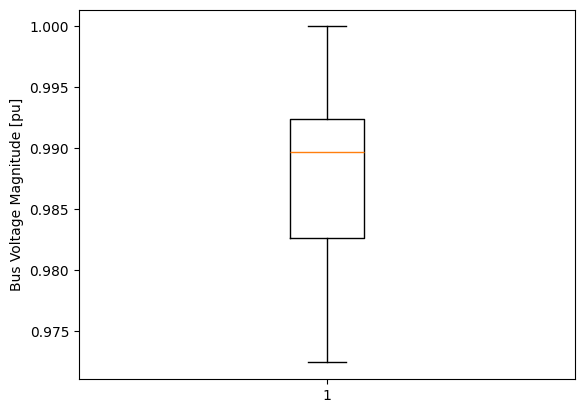

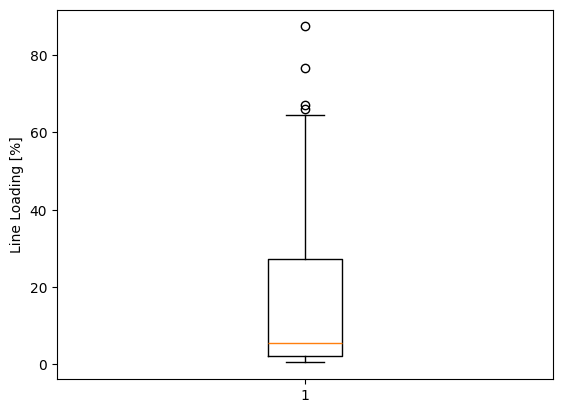

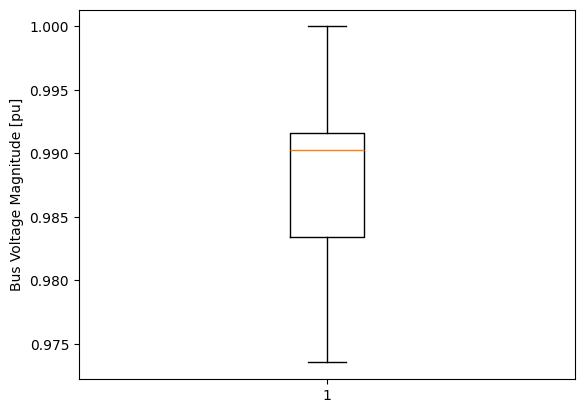

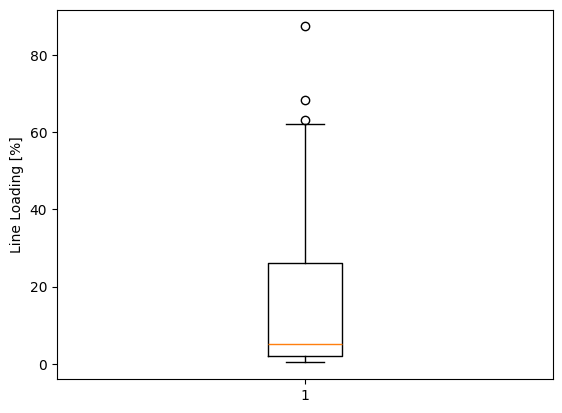

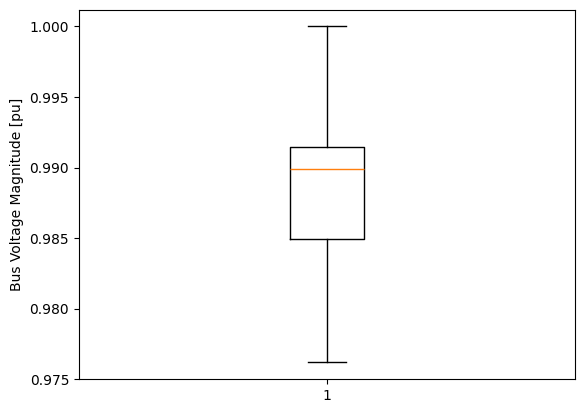

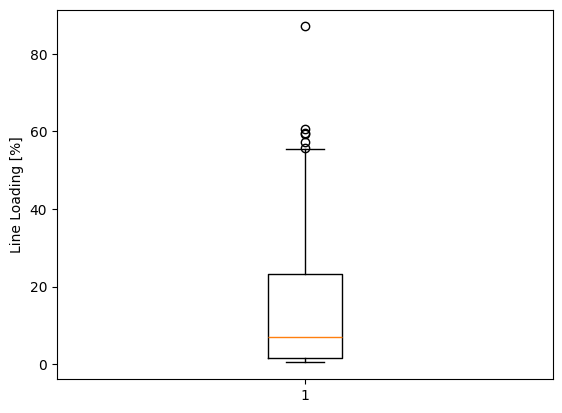

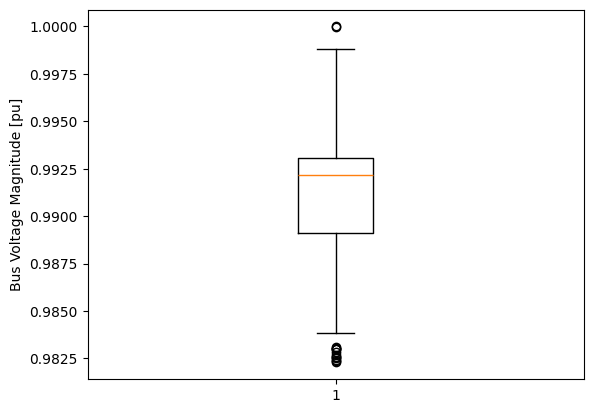

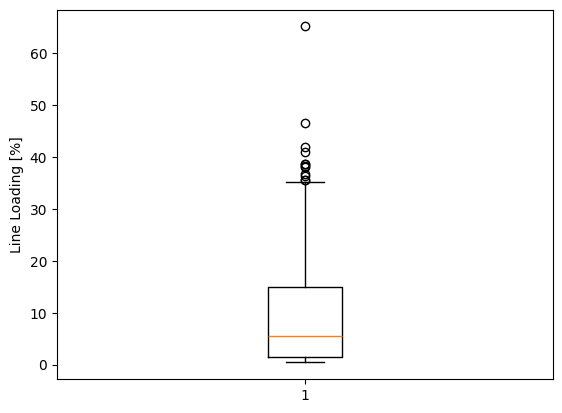

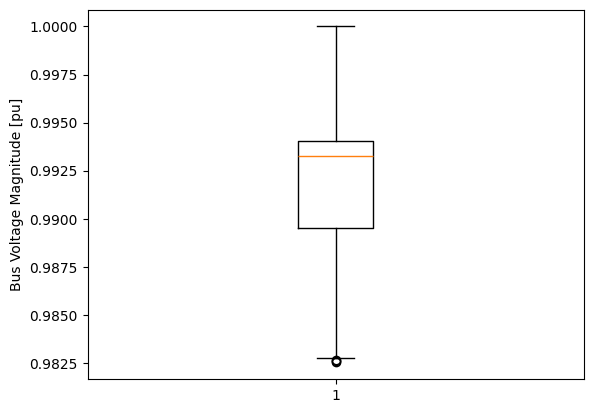

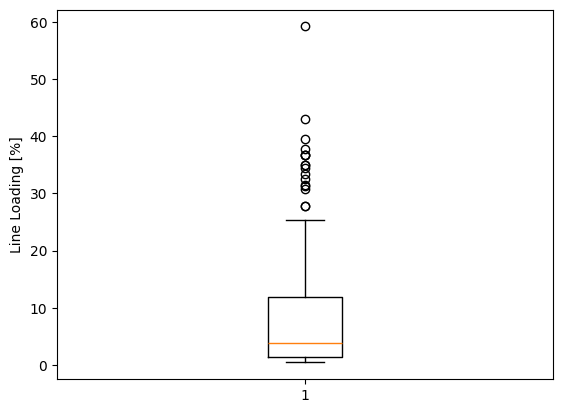

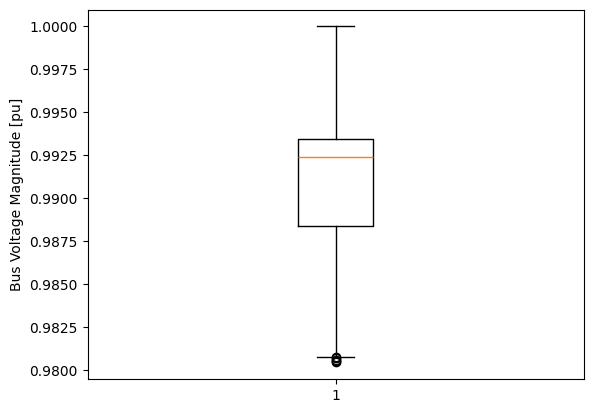

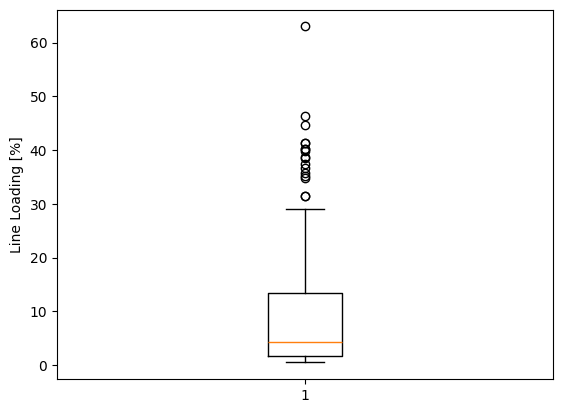

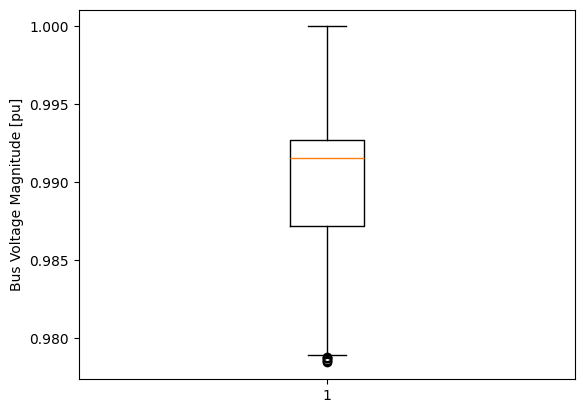

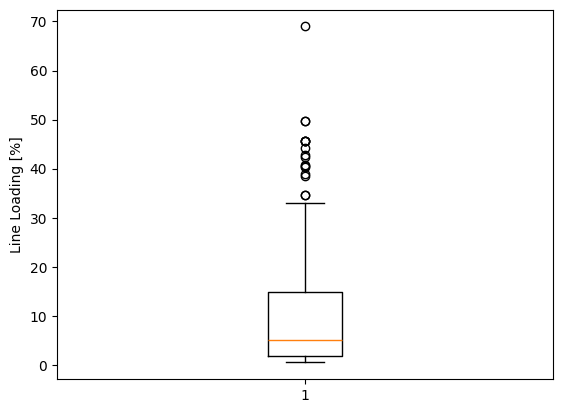

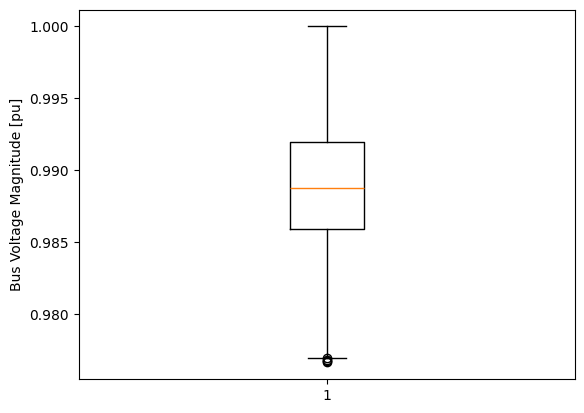

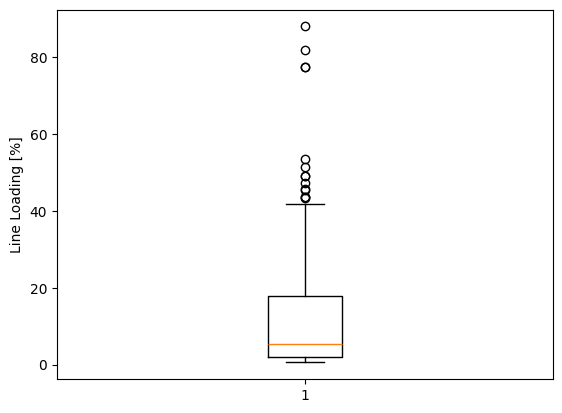

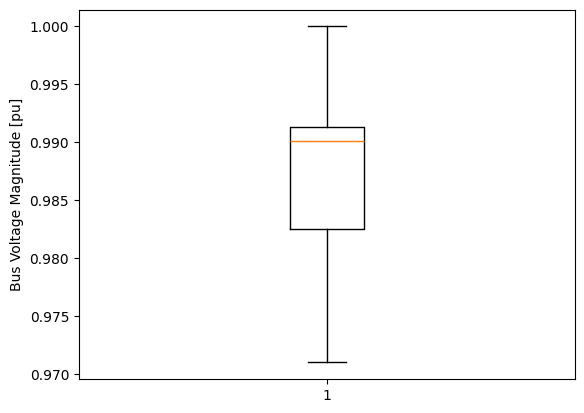

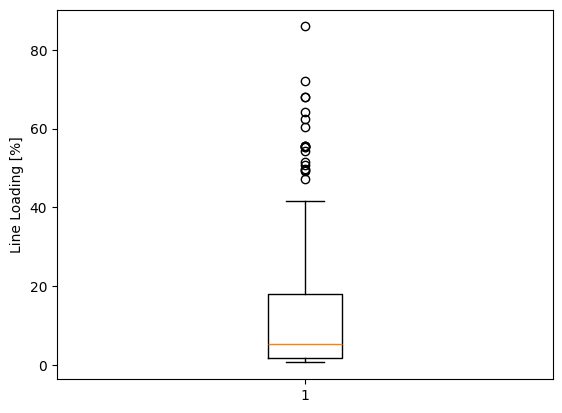

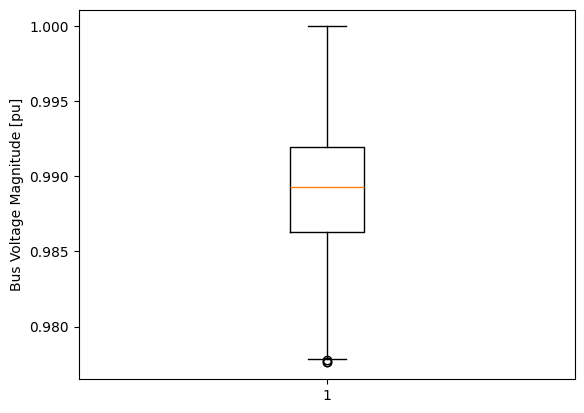

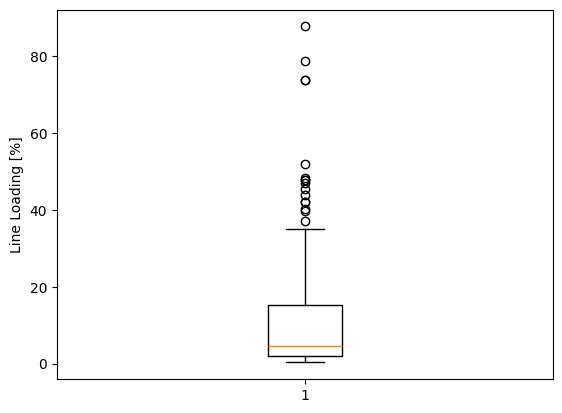

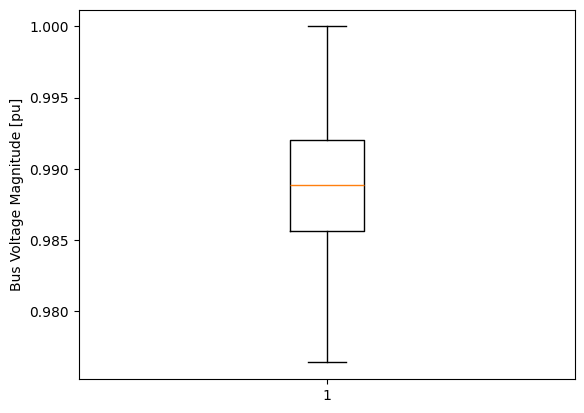

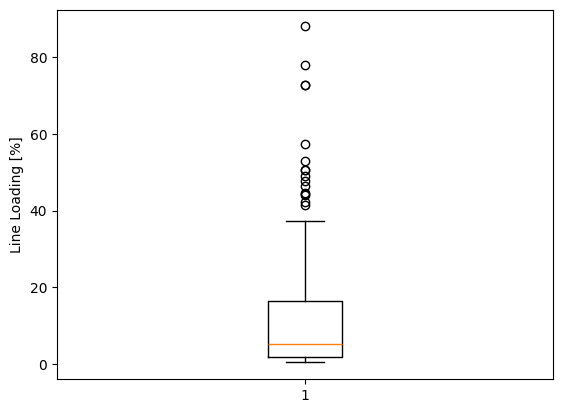

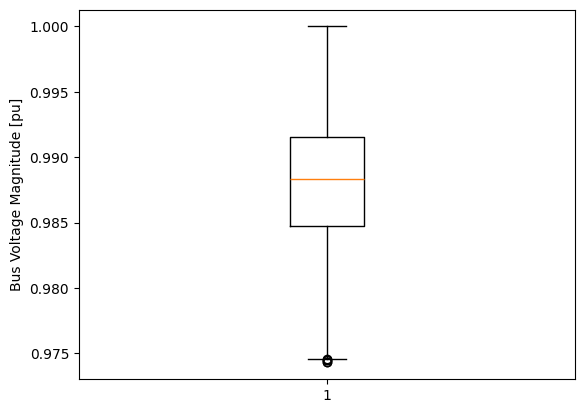

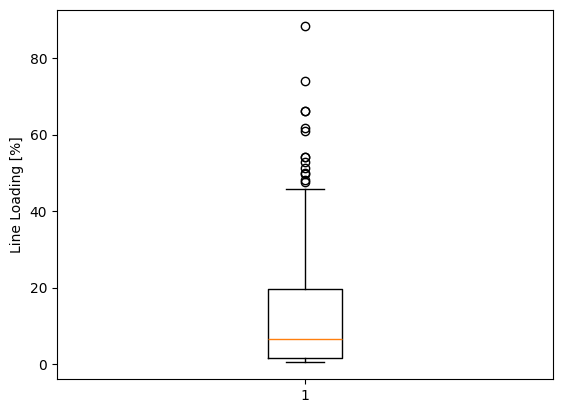

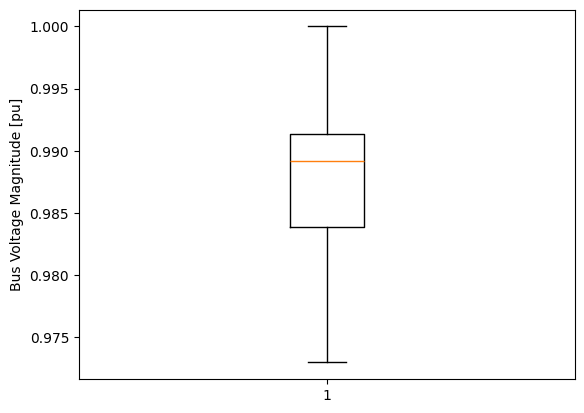

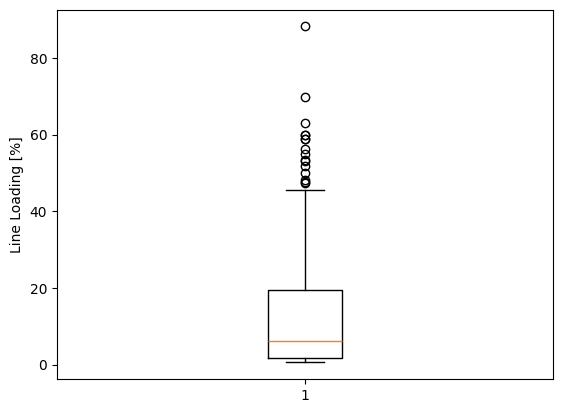

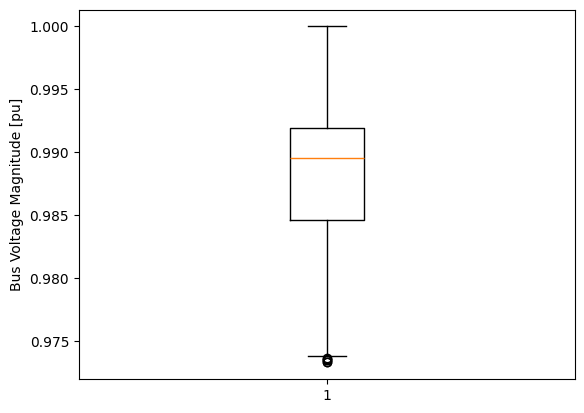

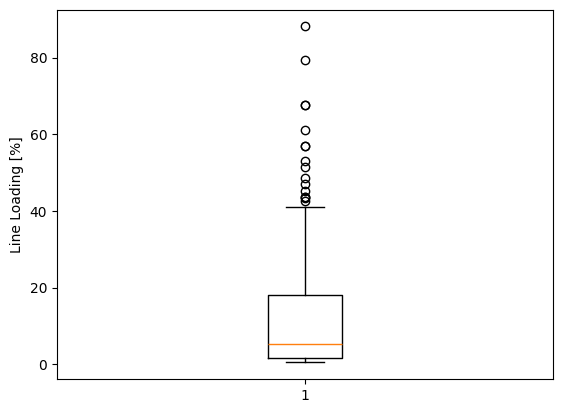

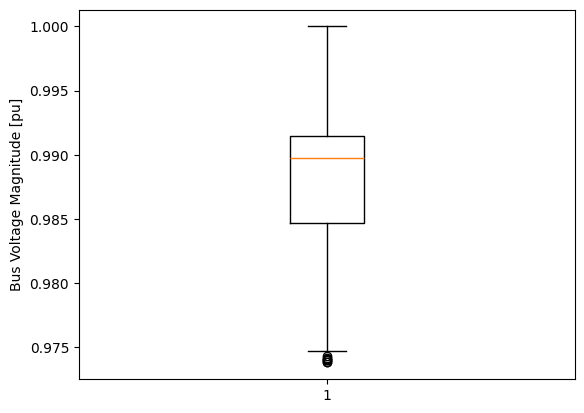

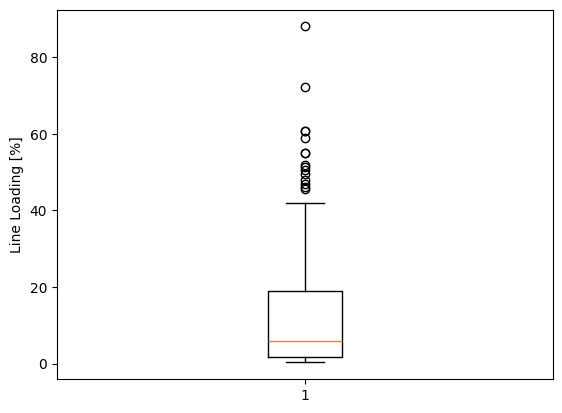

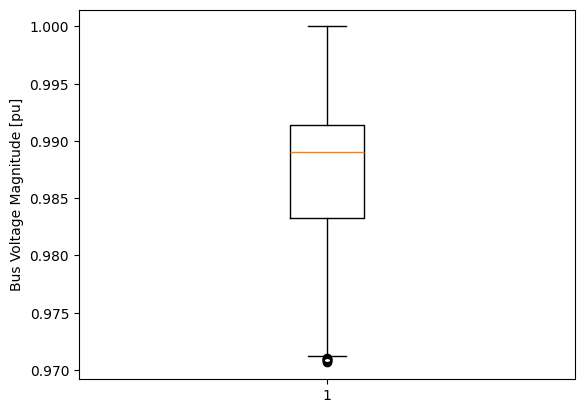

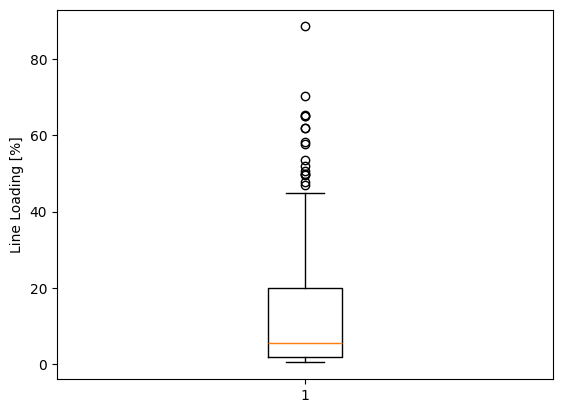

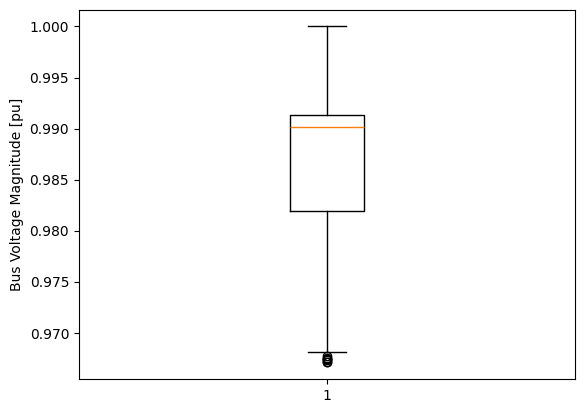

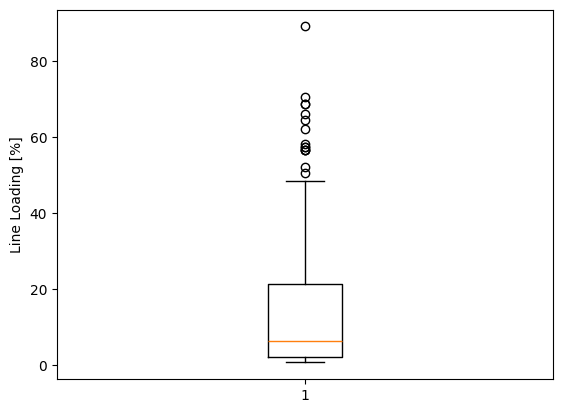

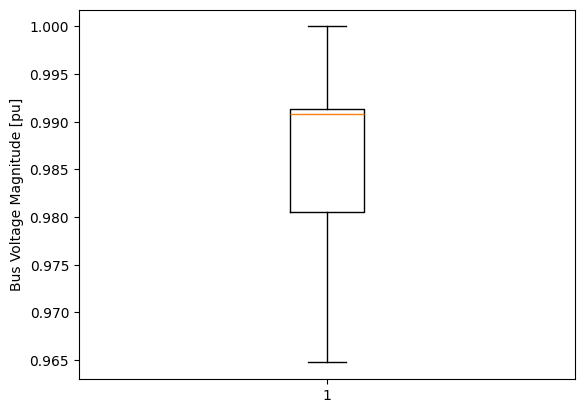

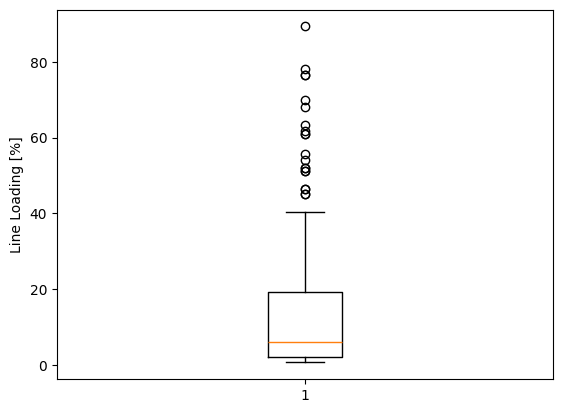

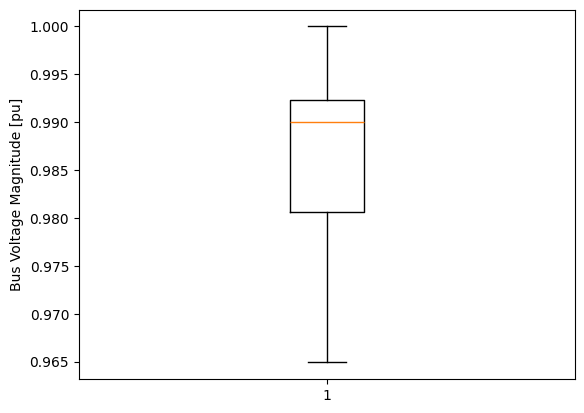

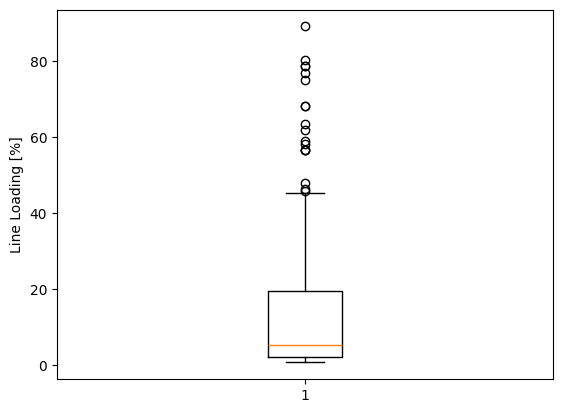

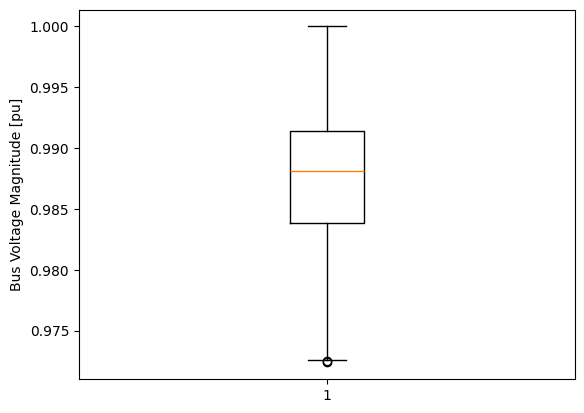

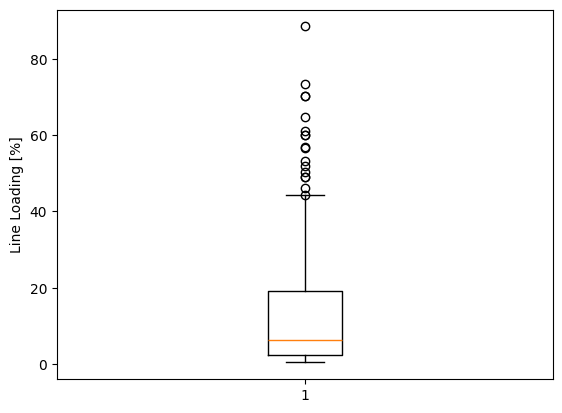

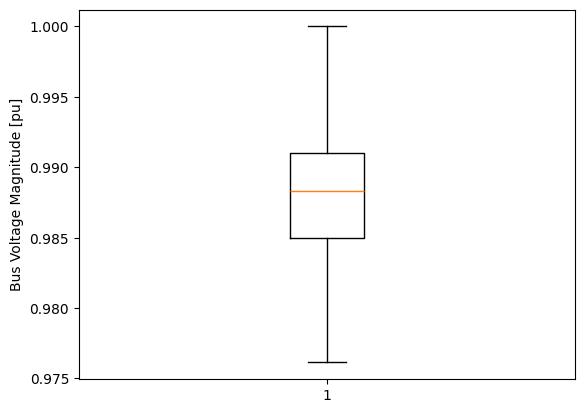

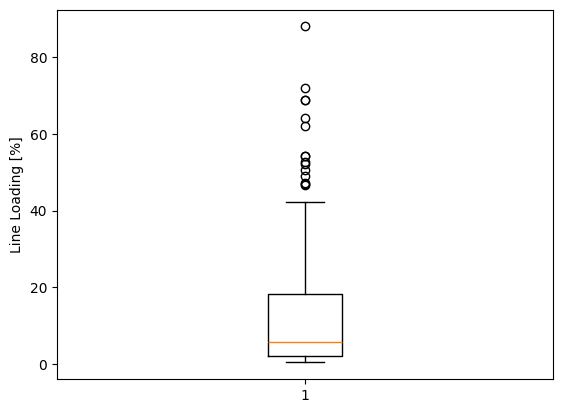

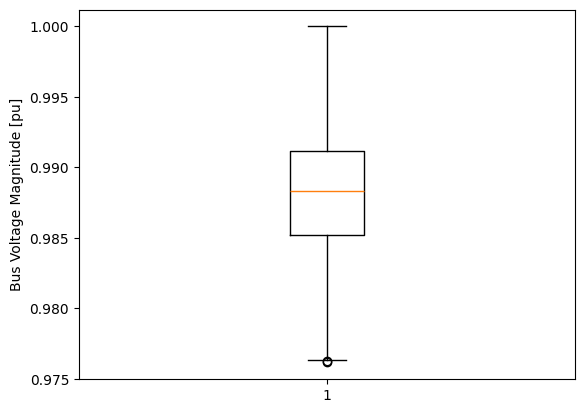

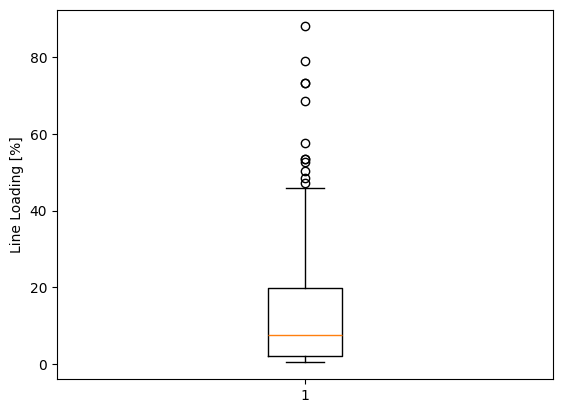

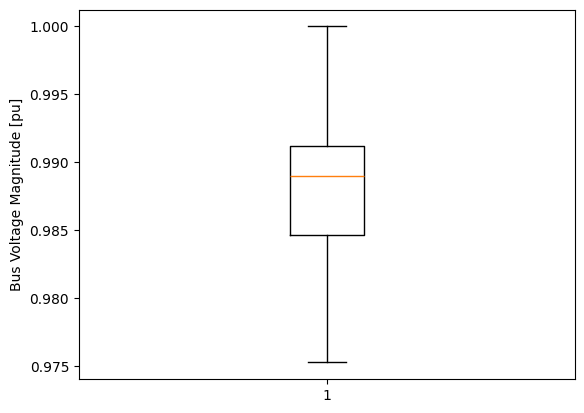

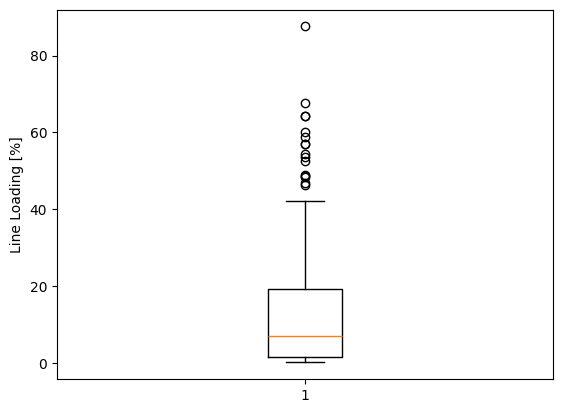

In [109]:
line_res = pd.DataFrame()
bus_res = pd.DataFrame()
ev_res = pd.DataFrame(index=net.storage.index)
# ev_res[-1] = pd.Series([0]*len(ev_res))

for t in range(24):
    max_attempt=100
    rand_state=1
    attempt=0
    # Reduce Line Loading Limit
    net.line['max_loading_percent']=85

    net.load.loc[net.load.category == 'base', 'p_mw'] = base_p.loc[t].values
    net.load.loc[net.load.category=='base','q_mvar'] = base_q.loc[t].values

    # #PV
    net.sgen.loc[net.sgen.type=='PV','p_mw'] = pv_p.loc[t].values
    net.sgen.loc[net.sgen.type=='PV','q_mvar'] = pv_q.loc[t].values
    net.sgen.loc[net.sgen.type=='PV','max_p_mw'] = pv_p.loc[t].values
    # No limit on PV reactive power yet, later apply pf = 0.97
    net.sgen.loc[net.sgen.type=='PV','max_q_mvar'] = pv_p.loc[t].values
    net.sgen.loc[net.sgen.type=='PV','min_q_mvar'] = pv_p.loc[t].values*(-1)

    # #Heatpump
    net.load.loc[net.load.category == 'hp', 'p_mw'] = hp_p.loc[t].values
    net.load.loc[net.load.category == 'hp', 'q_mvar'] = hp_q.loc[t].values
    
    # #EV
    if len(net.storage)>0:
        net.storage['controllable']=True

        net.storage.loc[net.storage.type=='ev','p_mw'] = ev_p.loc[t].values
        # Sync currnet Battery SoC
        net.storage.loc[net.storage.type=='ev','soc_percent'] = net.storage['person'].map(SoC_dict)

        # Randomly sample 70% of the evs
        sampled_rows = net.storage.sample(frac=0.7, random_state=rand_state)
        # Change the 'controllable' column value to False for the sampled rows
        net.storage.loc[sampled_rows.index, 'controllable'] = False

        # Recalculate ev's max/min_p_mw
        net.storage.loc[net.storage.type=='ev','max_p_mw'] = net.storage.apply(lambda row:ev_max_p_mw(t,ev_park_t.loc[t][row.name],row,ev_res.loc[row.name]),axis=1)
        net.storage.loc[net.storage.type=='ev','min_p_mw'] = net.storage.apply(lambda row:ev_min_p_mw(t,ev_park_t.loc[t][row.name],row,ev_res.loc[row.name]),axis=1)

    ########################################################
    ########################################################
    while attempt<max_attempt:
        try:
            # Run DCOPF with 90% line loading limit
            pp.rundcopp(net)
            break
        except Exception as e: 
            rand_state+=1
            if len(net.storage)>0:
                net.storage['controllable']=True
                # Randomly sample 70% of the evs
                sampled_rows = net.storage.sample(frac=0.7, random_state=rand_state)
                # Change the 'controllable' column value to False for the sampled rows
                net.storage.loc[sampled_rows.index, 'controllable'] = False

            if attempt==int(0.5*max_attempt):
                net.line['max_loading_percent']=100 # relax line loading limit after half of iterations

            try:
                pp.rundcopp(net)
                break
            except Exception:
                attempt+=1
                if attempt>max_attempt:
                    raise pp.optimal_powerflow.OPFNotConverged("Optimal Power Flow did not converge after several attempts!")

            
    #Clean up small charging power
    net.res_storage.p_mw.loc[((net.res_storage.p_mw>-1e-7) & (net.res_storage.p_mw<0))|((net.res_storage.p_mw>0) & (net.res_storage.p_mw<1e-7))]=0 
    net.res_sgen.p_mw.loc[((net.res_sgen.p_mw>-1e-7) & (net.res_sgen.p_mw<0))|((net.res_sgen.p_mw>0) & (net.res_sgen.p_mw<1e-7))]=0 

    net.sgen.loc[net.sgen.type=='PV','p_mw'] = net.res_sgen.p_mw
    net.sgen.loc[net.sgen.type=='PV','q_mvar'] = np.tan(np.arccos(0.97))*net.res_sgen.p_mw
    net.sgen.loc[net.sgen.type=='PV','max_p_mw'] = net.res_sgen.p_mw
    net.sgen.loc[net.sgen.type=='PV','max_q_mvar'] = np.tan(np.arccos(0.9))*net.res_sgen.p_mw
    net.sgen.loc[net.sgen.type=='PV','min_q_mvar'] = np.tan(np.arccos(0.9))*net.res_sgen.p_mw*(-1)
    net.storage.loc[net.storage.type == 'ev', 'p_mw'] = net.res_storage.p_mw
 
    # Run AC power flow to check voltage and line loading
    pp.runpp(net)
    plt.figure()
    plt.boxplot(net.res_bus.vm_pu)
    plt.ylabel("Bus Voltage Magnitude [pu]")
    # plt.savefig(f"{mv_folder_path}/bus_vm_pu_{t}.jpg")
    plt.figure()
    plt.boxplot(net.res_line.loading_percent)
    plt.ylabel("Line Loading [%]")
    # plt.savefig(f"{mv_folder_path}/line_loading_{t}.jpg")

    # Save net at time t
    pp.to_excel(net,f"time_{t}_{folder}.xlsx")
    line_res[t] = net.res_line.loading_percent
    bus_res[t] = net.res_bus.vm_pu
    ev_res[t] = net.res_storage.p_mw

    if len(net.storage)>0:
        # #Update SoC
        net.res_storage['SoC_change'] = net.storage.apply(lambda row:row.SoC_change if row.arr_time_idx==t else 0, axis=1)
        net.res_storage['delta_energy'] = net.res_storage['p_mw']*ev_park_t.loc[t] - net.res_storage['SoC_change']/100*net.storage.max_e_mwh
        SoC_change=(net.res_storage.groupby(net.storage.person)['delta_energy'].sum())/(net.storage.groupby('person')['max_e_mwh'].first())*100
        for key, value in SoC_change.items():
            SoC_dict[key]+=value
        SoC_t[t] = pd.Series(SoC_dict)
        # #Store this sns charging situation]
if len(ev_load_profile)>0:
    SoC_t.to_csv(f"{folder}_SoC_t.csv")

In [127]:
(SoC_t>130).any(axis=1)

164792     False
362638     False
745229     False
2315434    False
2317337    False
2319678    False
2369903    False
2371090    False
2371248    False
2389418    False
2392110    False
2465920    False
2512337    False
2574723    False
2575083    False
2585277    False
2756786    False
4166001    False
7207681    False
7234487    False
7234917    False
7234968    False
7236572    False
7236627    False
7237472    False
7238005    False
7238020    False
7238034    False
7238036    False
7238045    False
7238080    False
7238102    False
7238107    False
7238110    False
7238119    False
7238152    False
7238199    False
7238279     True
7238301    False
7238350    False
7238406    False
7240009    False
7242883    False
7247989    False
7253309    False
7369021    False
7381774    False
7398820    False
7487953    False
7554816    False
7557414    False
7559903    False
7560414    False
7564407    False
7566757    False
7566777    False
7566784    False
7566785    False
7566791    Fal

In [130]:
ev_res.loc[[52,53]]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
52,0.004406,0.004865,0.006218,0.006125,0.007,0.007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0
53,0.000000,0.000000,0.000000,0.000000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0043,0.0


In [128]:
net.storage[net.storage.person==7238279]

,name,bus,p_mw,q_mvar,sn_mva,soc_percent,min_e_mwh,max_e_mwh,scaling,in_service,type,person,chg_rate,arr_time_idx,park_end_time_idx,SoC_change,next_SoC_change,next_trip_e,min_p_mw,max_p_mw,min_q_mvar,max_q_mvar,controllable
52,ev_7238279_208984_42_1,42,0.0,0.0,NaN,142.906335,0.005,0.07,1.0,True,ev,7238279.0,0.007,-7.0,6.0,0.000000,0.0,0.003599,0.0,0.0,0.0,0.0,True
53,ev_7238279_208987_42_22,42,0.0,0.0,NaN,142.906335,0.005,0.07,1.0,True,ev,7238279.0,0.007,17.0,30.0,-38.628571,0.0,0.003308,0.0,0.0,0.0,0.0,False


In [129]:
SoC_t.loc[7238279]

-1      47.257143
 0      53.552067
 1      60.502735
 2      69.385164
 3      78.134907
 4      88.134907
 5      98.134907
 6      98.134907
 7      98.134907
 8      98.134907
 9      98.134907
 10     98.134907
 11     98.134907
 12     98.134907
 13     98.134907
 14     98.134907
 15     98.134907
 16     98.134907
 17    136.763478
 18    136.763478
 19    136.763478
 20    136.763478
 21    136.763478
 22    142.906335
 23    142.906335
Name: 7238279, dtype: float64